Step 1: Define a Proxy Variable for Default Risk (Good/Bad Labels)
Since the dataset lacks a true "default" label, you must create one using RFMS metrics derived from transaction behavior. Here’s how:

1.1 Calculate RFMS Features
From your processed training data (x_train_processed.csv), compute:

Recency (R): Days since the customer’s last transaction (lower = better).

Frequency (F): Total number of transactions (higher = better).

Monetary (M): Total transaction amount (higher = better).

Stability (S): Consistency of transactions (e.g., standard deviation of transaction intervals; lower = better).

In [3]:
import pandas as pd
import numpy as np

# Load processed training data
x_train = pd.read_csv('../data/processed/x_train_processed.csv')

# Convert TransactionStartTime to datetime
x_train['TransactionStartTime'] = pd.to_datetime(x_train['TransactionStartTime'])

# Group by CustomerId (one row per customer)
customer_data = x_train.groupby('CustomerId').agg(
    LastTransaction=('TransactionStartTime', 'max'),  # For Recency
    Frequency=('Transaction_Count', 'first'),         # Already aggregated
    Monetary=('Total_Transaction_Amount', 'first'),   # Already aggregated
    AvgTransactionInterval=('TransactionStartTime', lambda x: x.sort_values().diff().dt.days.mean()),  # Mean interval
    StdTransactionInterval=('TransactionStartTime', lambda x: x.sort_values().diff().dt.days.std())    # Std dev of intervals
).reset_index()


Calculating Recency and Stability

In [5]:
# Recency: Days since the last transaction (relative to the latest date in the dataset)
max_date = x_train['TransactionStartTime'].max()
customer_data['Recency'] = (max_date - customer_data['LastTransaction']).dt.days

# Drop 'LastTransaction' after calculating Recency
customer_data.drop(columns=['LastTransaction'], inplace=True)

# Stability: Std dev of transaction intervals
# Replace NaN with 0 for customers with only one transaction
customer_data['Stability'] = customer_data['StdTransactionInterval'].fillna(0)

# Drop intermediate column 'StdTransactionInterval'
customer_data.drop(columns=['StdTransactionInterval'], inplace=True)

Step 2: Assign Good/Bad Labels
2.1 Define Thresholds (Example)

In [6]:
# Define thresholds for Good/Bad classification
thresholds = {
    'Recency': customer_data['Recency'].quantile(0.3),      # Top 30% (Lower = better)
    'Frequency': customer_data['Frequency'].quantile(0.7),  # Top 30% (Higher = better)
    'Monetary': customer_data['Monetary'].quantile(0.7),    # Top 30% (Higher = better)
    'Stability': customer_data['Stability'].quantile(0.3)   # Top 30% (Lower = better)
}

# Display thresholds for verification
print("Thresholds for Good/Bad classification:")
for feature, value in thresholds.items():
    print(f"{feature}: {value:.2f}")

Thresholds for Good/Bad classification:
Recency: 7.00
Frequency: 14.00
Monetary: 50000.00
Stability: 0.00


2.2 Label Customers

In [7]:
# Label customers as Good (1) or Bad (0) based on thresholds
customer_data['Label'] = customer_data.apply(
    lambda row: int(
        (row['Recency'] <= thresholds['Recency']) &
        (row['Frequency'] >= thresholds['Frequency']) &
        (row['Monetary'] >= thresholds['Monetary']) &
        (row['Stability'] <= thresholds['Stability'])
    ),
    axis=1
)

# Save the proxy labels to a CSV file
output_path = '../data/processed/y_train_proxy.csv'
customer_data[['CustomerId', 'Label']].to_csv(output_path, index=False)

print(f"Proxy labels saved to: {output_path}")

Proxy labels saved to: ../data/processed/y_train_proxy.csv


In [8]:
# Define aggregation rules for transaction-level features
agg_rules = {
    'Transaction_Hour': 'mean',                  # Average transaction hour
    'Transaction_Day': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Most frequent transaction day
    'Transaction_Month': 'mean',                # Average transaction month
    'Transaction_Year': 'mean',                 # Average transaction year
    # Add other features as needed
}

# Group transaction-level features by CustomerId
customer_engineered = x_train.groupby('CustomerId').agg(agg_rules).reset_index()

# Merge RFMS features with engineered features
customer_final = customer_data.merge(customer_engineered, on='CustomerId', how='left')

# Display merged data shape and sample
print(f"Merged data shape: {customer_final.shape}")
print(customer_final.head())

Merged data shape: (3582, 11)
        CustomerId  Frequency  Monetary  AvgTransactionInterval  Recency  \
0     CustomerId_1          1  -10000.0                     NaN       83   
1  CustomerId_1001          4   10000.0                0.000000       89   
2  CustomerId_1002          8    3325.0                8.571429       27   
3  CustomerId_1003          6   20000.0                0.000000       11   
4  CustomerId_1004          1    2000.0                     NaN       52   

   Stability  Label  Transaction_Hour  Transaction_Day  Transaction_Month  \
0   0.000000      0         16.000000               21             11.000   
1   0.000000      0          8.000000               16             11.000   
2  13.464238      0         15.000000               10             10.125   
3   0.000000      0         14.333333                1              2.000   
4   0.000000      0         18.000000               22             12.000   

   Transaction_Year  
0          2018.000  
1     

In [9]:
%pip install scorecardpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[INFO] creating woe binning ...


c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "Label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_co

Binning completed successfully.
[INFO] converting into woe values ...
Transformation to WoE completed successfully.
WoE-transformed data saved to ../data/processed/x_train_woe.csv.


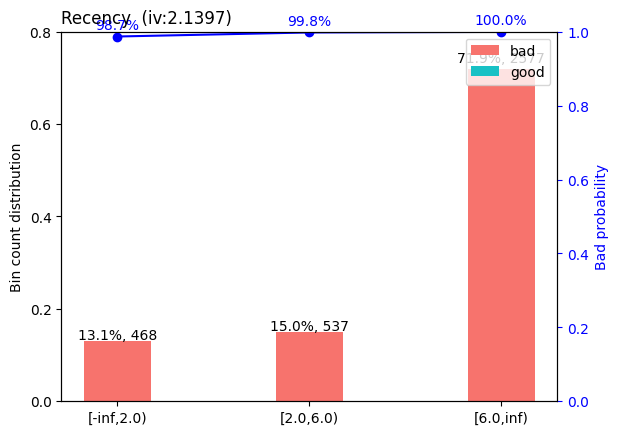

In [10]:
import scorecardpy as sc

# Step 1: Prepare data
# Ensure the necessary columns are present and drop unnecessary ones
X_train = customer_final.drop(columns=['CustomerId', 'Label'])  # Features
y_train = customer_final['Label']  # Target

# Step 2: Automatic binning
try:
    # Binning all features automatically based on the target label
    bins = sc.woebin(pd.concat([X_train, y_train], axis=1), y='Label', positive='bad|0')
    print("Binning completed successfully.")
except Exception as e:
    print(f"Error during binning: {e}")
    raise

# Step 3: Visualize binning for a specific feature (e.g., Recency)
if 'Recency' in bins:
    sc.woebin_plot(bins['Recency'])
else:
    print("Feature 'Recency' not found in bins.")

# Step 4: Transform features to WoE (Weight of Evidence)
try:
    # Apply the bins to transform data into WoE values
    X_train_woe = sc.woebin_ply(X_train, bins)
    print("Transformation to WoE completed successfully.")
except Exception as e:
    print(f"Error during WoE transformation: {e}")
    raise

# Step 5: Save WoE-transformed data
output_path = '../data/processed/x_train_woe.csv'
X_train_woe.to_csv(output_path, index=False)
print(f"WoE-transformed data saved to {output_path}.")

In [14]:
# Step 1: Calculate Information Value (IV)
try:
    iv = sc.iv(customer_final, y='Label', positive='bad|0')  # IV calculation
    print("Information Value (IV) calculation completed successfully.")
except Exception as e:
    print(f"Error during IV calculation: {e}")
    raise

# Step 2: Sort Features by IV
try:
    iv_sorted = iv.sort_values(by='info_value', ascending=False)
    print("Features sorted by IV.")
except KeyError as e:
    print(f"Error during sorting: Missing 'info_value' column. {e}")
    raise

# Step 3: Save IV Results
output_path_iv = '../data/interim/iv_results.csv'
try:
    iv_sorted.to_csv(output_path_iv, index=False)
    print(f"IV results saved to {output_path_iv}.")
except Exception as e:
    print(f"Error saving IV results: {e}")
    raise

# Step 4: Display Top Features
strong_features = iv_sorted[iv_sorted['info_value'] > 0.1]  # Features with IV > 0.1
if not strong_features.empty:
    print("Top features with IV > 0.1:")
    print(strong_features)
else:
    print("No features with IV > 0.1 found.")

c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "Label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


Information Value (IV) calculation completed successfully.
Features sorted by IV.
IV results saved to ../data/interim/iv_results.csv.
Top features with IV > 0.1:
                 variable  info_value
8        Transaction_Year    4.278573
6       Transaction_Month    3.558057
5               Frequency    3.380562
9  AvgTransactionInterval    2.760440
3               Stability    2.564817
0        Transaction_Hour    2.084613
4                Monetary    1.602702
2                 Recency    0.516283
1         Transaction_Day    0.255569


In [22]:
import pickle

# Assuming you have already performed binning on the training data like this:
bins = sc.woebin(pd.concat([X_train, y_train], axis=1), y='Label', positive='bad|0')

# Save the binning results to a file
with open('../data/processed/bins.pkl', 'wb') as f:
    pickle.dump(bins, f)

print("Binning results saved successfully.")

[INFO] creating woe binning ...


c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "Label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\neba\Documents\credit-scoring-project\myenv\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_co

Binning on 3582 rows and 10 columns in 00:00:11
Binning results saved successfully.


In [19]:
# Assuming 'x_test' is your raw test dataset

# Step 1: Initialize 'x_test_processed' to start with a copy of x_test
x_test = pd.read_csv(r"../data/processed/X_test.csv") 
x_test_processed = x_test.copy()


# Step 2: Ensure 'TransactionStartTime' is in datetime format
x_test_processed['TransactionStartTime'] = pd.to_datetime(x_test_processed['TransactionStartTime'])

# Step 3: Calculate 'Frequency': Number of transactions per customer
x_test_processed['Frequency'] = x_test_processed.groupby('CustomerId')['TransactionId'].transform('count')

# Step 4: Calculate 'Monetary': Total transaction amount per customer
x_test_processed['Monetary'] = x_test_processed.groupby('CustomerId')['Amount'].transform('sum')

# Step 5: Calculate 'Recency': Time since the last transaction (in days)
max_date = x_test_processed['TransactionStartTime'].max()
x_test_processed['Recency'] = (max_date - x_test_processed.groupby('CustomerId')['TransactionStartTime'].transform('max')).dt.days

# Step 6: Calculate 'AvgTransactionInterval': Average days between transactions
x_test_processed['TransactionIntervals'] = x_test_processed.groupby('CustomerId')['TransactionStartTime'].transform(
    lambda x: x.sort_values().diff().dt.days
)
x_test_processed['AvgTransactionInterval'] = x_test_processed.groupby('CustomerId')['TransactionIntervals'].transform('mean')

# Step 7: Calculate 'Stability': Standard deviation of transaction intervals
x_test_processed['Stability'] = x_test_processed.groupby('CustomerId')['TransactionIntervals'].transform('std')

# Step 8: Ensure that missing values for product, category, and channel columns are filled with 0 (as done for x_train_processed)
product_columns = [col for col in x_test_processed.columns if 'ProductId_' in col]
category_columns = [col for col in x_test_processed.columns if 'ProductCategory_' in col]
channel_columns = [col for col in x_test_processed.columns if 'ChannelId_' in col]

# Step 9: Fill missing values with 0 for these columns
x_test_processed[product_columns] = x_test_processed[product_columns].fillna(0)
x_test_processed[category_columns] = x_test_processed[category_columns].fillna(0)
x_test_processed[channel_columns] = x_test_processed[channel_columns].fillna(0)

# At this point, 'x_test_processed' will have the necessary features calculated, and all missing values filled


In [23]:
import pandas as pd
import scorecardpy as sc
import pickle

# Step 1: Load the raw test data
x_test = pd.read_csv('../data/processed/x_test.csv')  

# Step 2: Load the binning results (from training process)
with open('../data/processed/bins.pkl', 'rb') as f:  # Load the saved binning rules
    bins = pickle.load(f)

# Step 3: Apply the WoE transformation to the test data
try:
    x_test_woe = sc.woebin_ply(x_test, bins)
    print("WoE transformation completed successfully.")
except Exception as e:
    print(f"Error during WoE transformation: {e}")
    raise

# Step 4: Save the transformed test data (WoE features) into a CSV file
output_path = '../data/processed/x_test_woe.csv'  # Save WoE-transformed data to this path
x_test_woe.to_csv(output_path, index=False)
print(f"WoE-transformed test data saved to {output_path}.")

[INFO] converting into woe values ...
WoE transformation completed successfully.
WoE-transformed test data saved to ../data/processed/x_test_woe.csv.
